In [2]:
!pip install -U keras-tuner

     |████████████████████████████████| 71kB 7.1MB/s  eta 0:00:01
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=181fd77ca7a9837b3dc81d2a5ff07496e74e1ffd1734df9cb0a6cf11b7dfcb59
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=5198781c79c7adf6a2860e61960efeb2becbbc59a5883fcbdcc0b12e26b399ef
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


# Problema Regressão - Pressão em asas de aeronaves
### Bruno Monteiro Accioli da Silva e Genebaldo

In [101]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1, l2, l1_l2
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import kerastuner
from kerastuner.tuners import RandomSearch

sns.set(style='whitegrid', font_scale=1.2)

In [2]:
dataset_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat'
columns=['frequency', 'angle', 'chord_length', 'velocity', 'suction_thickness', 
         'pressure']
df = pd.read_csv(dataset_url, sep='\t', header=None, names=columns)
df.head()

,frequency,angle,chord_length,velocity,suction_thickness,pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


## Análise Exploratória

### Distribuição das variáveis

[]

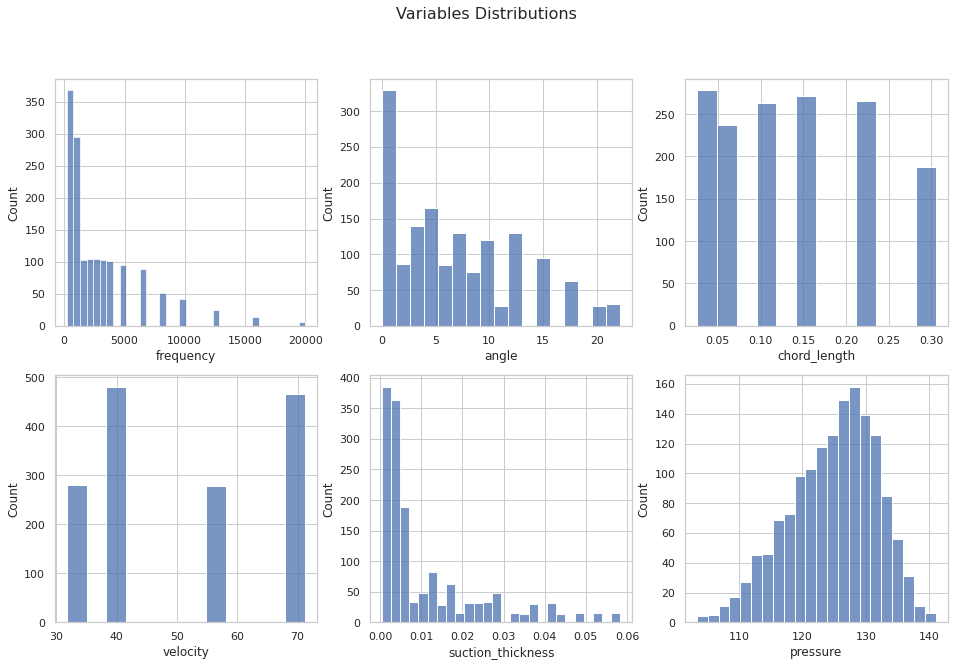

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,10))
lin=0
col=0
for i, column in enumerate(columns):
  if i <= 2:
    lin = 0
    col = i
  else:
    lin = 1
    col = i-3
  ax[lin,col] = sns.histplot(x=column , data=df, ax=ax[lin,col])
_ = fig.suptitle('Variables Distributions', size=16)
plt.plot()

### Avaliação de outliers

[]

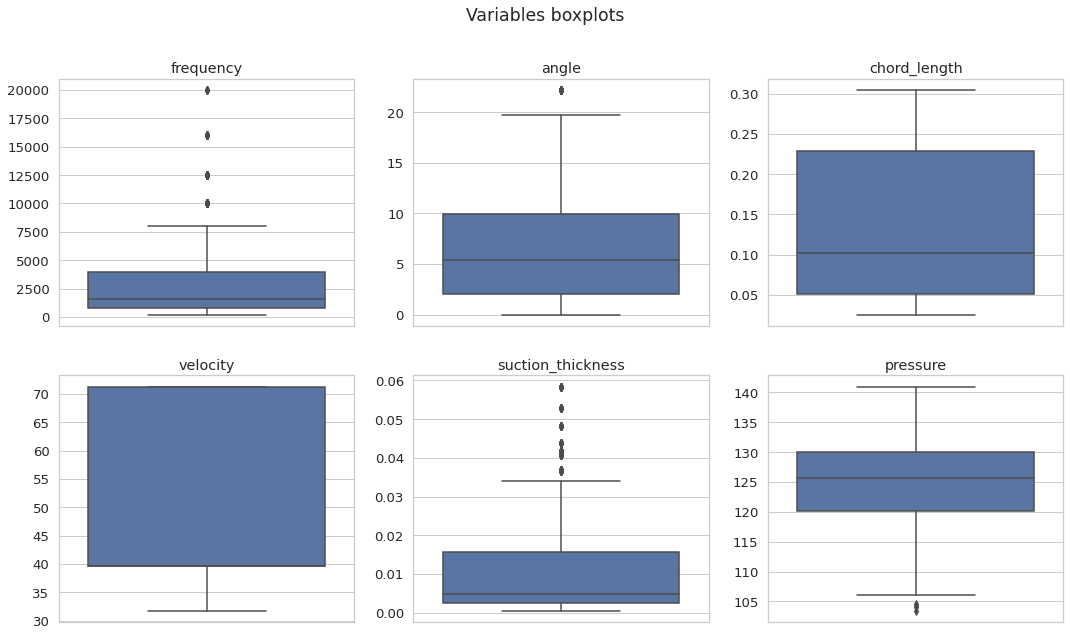

In [228]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10))
lin=0
col=0
for i, column in enumerate(columns):
  if i <= 2:
    lin = 0
    col = i
  else:
    lin = 1
    col = i-3
  _ = sns.boxplot(y=column, data=df, ax=ax[lin,col])
  ax[lin,col].set_ylabel('')
  ax[lin,col].set_title(column) 
_ = fig.suptitle('Variables boxplots')
plt.plot()

### Relação das variáveis de entrada com a variável de saída (pressão)

[]

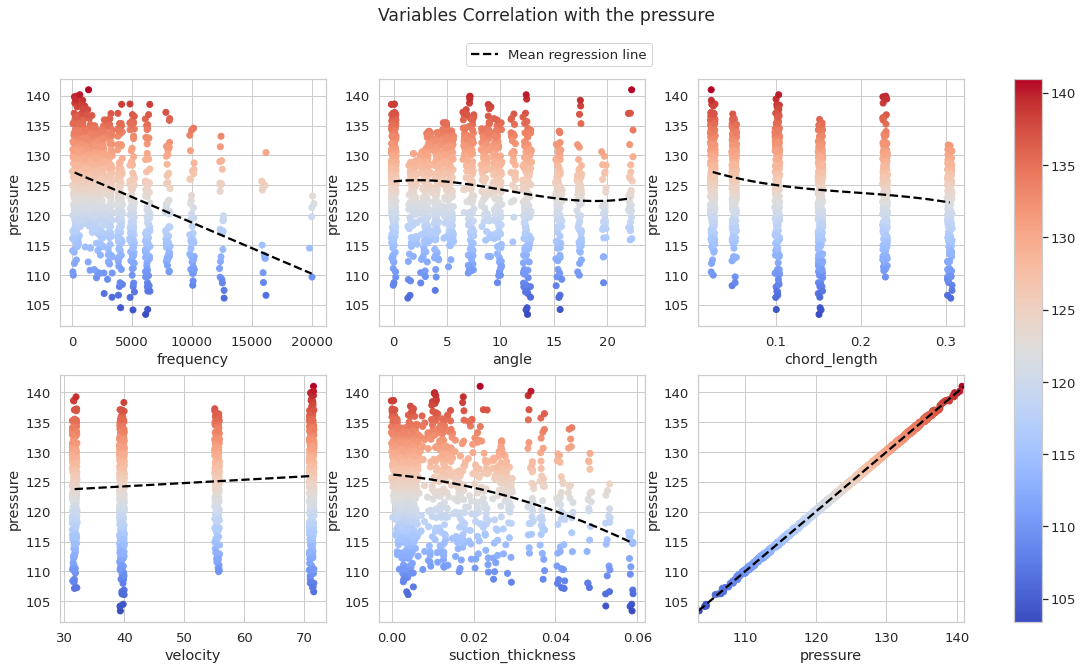

In [145]:
def add_jitter(variable, intensity=0.1):
  var_range = variable.max() - variable.min()
  noise = (intensity * var_range) * np.random.uniform(low=-1.0, high=1.0, size=len(variable))
  return variable + noise

reg_line_order = [1, 3, 3, 1, 2, 1]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10))
lin=0
col=0
for i, column in enumerate(columns):
  if i <= 2:
    lin = 0
    col = i
  else:
    lin = 1
    col = i-3
  collection = ax[lin,col].scatter(x=add_jitter(df[column], 0.01), 
                                  y=df['pressure'], c=df['pressure'],
                                  cmap='coolwarm', alpha=1)
  sns.regplot(x=column, y='pressure', data=df, ax=ax[lin,col],
              x_estimator=np.mean, x_bins=20, ci=None, marker=None, 
              order=reg_line_order[i], color='black', n_boot=1,
              scatter_kws={"alpha" : 0}, 
              line_kws={'linestyle':'--', 'label':'Mean regression line'}) 
_ = fig.suptitle('Variables Correlation with the pressure')
fig.colorbar(collection, ax=ax, orientation='vertical', fraction=.05)
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc = (0.43, 0.9))
plt.plot()

### Correlação das variáveis

Aqui medimos a correlação entre as variáveis utilizando o Coeficiente de correlação de postos de Spearman que é capaz de medir o quão bem uma função monotônica é capaz de descrever a relação entre duas variáveis. Os valores do coeficiente vão de -1 a +1, e uma relação monotônica perfeita terá valores de -1 ou +1, enquanto variáveis que não possuem nenhuma correlação monotônica possuirão o coeficiente igual a 0.

Os coeficientes de correlação obtidos permitem algumas conclusões:

- As variáveis suction_thickness e angle possuem uma correlação monotônica muito forte (0.88).
- As variáveis velocity e angle possuem correlação muito baixa com pressure.

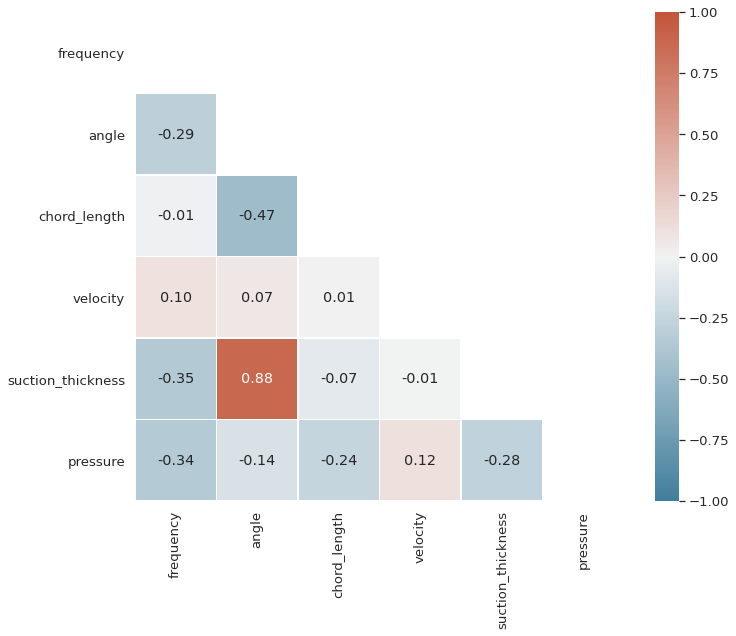

In [222]:
correlation_matrix = df.corr(method='spearman')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax = sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, 
                 center=0, annot=True, fmt=".2f", square=True, linewidths=.5, 
                  cbar_kws={"shrink": 1}, ax=ax)

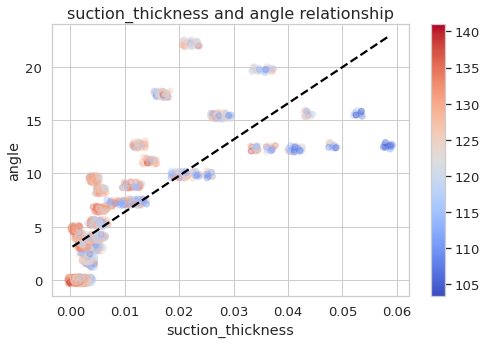

In [219]:
fig, ax = plt.subplots(figsize=(8, 5))

cmap = cm.coolwarm
ax = sns.regplot(x='suction_thickness', y='angle', data=df, scatter=False,
                 ci=None, line_kws={'color':'black', 'linestyle': '--', 
                                    'label':"Regression line"}, ax=ax)
collection = ax.scatter(x=add_jitter(df['suction_thickness'], 0.015), 
                        y=add_jitter(df['angle'], 0.015), alpha=0.3, 
                        c=df['pressure'], cmap=cmap)
_ = ax.set_title('suction_thickness and angle relationship', size=16)
color_bar = plt.colorbar(collection)
color_bar.set_alpha(1)
color_bar.draw_all()

### Verificação de valores faltantes

Verificamos abaixo que nenhuma das variáveis possui valores faltantes, logo não se faz necessário o tratamento dessa questão.

In [223]:
df.isna().sum()

frequency            0
angle                0
chord_length         0
velocity             0
suction_thickness    0
pressure             0
dtype: int64

## Treinamento de modelos

In [83]:
def plot_history(history, title=''):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig,ax = plt.subplots(figsize=(10,6))

    ax = sns.lineplot(x='epoch', y='mse', data=hist, label='Train Error', ax=ax)
    ax = sns.lineplot(x='epoch', y='val_mse', data=hist, label='Val Error', ax=ax)

    ax.set_ylim([0, max(hist['mse'].max(), hist['val_mse'].max())])
    ax.set_xlim([0, hist['epoch'].max()])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Mean Squared Error')
    ax.set_title(title, size=16)
    ax.set_xticks(hist['epoch'])

    plt.show()

Separando conjunto de dados em treino e teste

In [6]:
input_cols = ['frequency', 'angle', 'chord_length', 'velocity', 'suction_thickness']
target = 'pressure'

train_size = round(0.7 * len(df))
validation_size = round(0.15 * len(df))
test_size = round(0.15 * len(df))

X = df[input_cols]
y = df[target].to_frame()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                    random_state=100)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=validation_size,
                                                  random_state=100)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"\nX_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

print(f"\nX_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1053, 5)
y_train shape: (1053, 1)

X_val shape: (225, 5)
y_val shape: (225, 1)

X_test shape: (225, 5)
y_test shape: (225, 1)


Para facilitar a convergência do treinamento da rede que é feito através do algoritmo de gradiente descendente, é importante que as variáveis de entrada e saída tenham aproximadamente a mesma escala.

Por isso, a escala das variáveis será ajustada para facilitar a convergência através da técnica MinMaxScaler para que todas as variáveis passem a ter valor máximo igual a 1 e valor mínimo igual a 0.

In [7]:
print('Estatística das entradas do conjunto de treino antes do processo de normalização')
X_train.describe().loc[['mean', 'std', 'min', 'max'], :]

Estatística das entradas do conjunto de treino antes do processo de normalização


,frequency,angle,chord_length,velocity,suction_thickness
mean,2866.377018,6.722697,0.134888,51.046344,0.010908
std,3166.255360,5.958266,0.094076,15.396055,0.012879
min,200.000000,0.000000,0.025400,31.700000,0.000401
max,20000.000000,22.200000,0.304800,71.300000,0.058411


In [8]:
scaler_input = MinMaxScaler()
X_train = pd.DataFrame(scaler_input.fit_transform(X_train), columns=input_cols)
X_val = pd.DataFrame(scaler_input.transform(X_val), columns=input_cols)
X_test = pd.DataFrame(scaler_input.transform(X_test), columns=input_cols)

scaler_output = MinMaxScaler()
y_train = pd.DataFrame(scaler_output.fit_transform(y_train), 
                       columns=[target])
y_val = pd.DataFrame(scaler_output.transform(y_val), 
                     columns=[target])
y_test = pd.DataFrame(scaler_output.transform(y_test), 
                      columns=[target])

print('Estatística das entradas do conjunto de treino após o processo de normalização')
X_train.describe().loc[['mean', 'std', 'min', 'max'], :]

Estatística das entradas do conjunto de treino após o processo de normalização


,frequency,angle,chord_length,velocity,suction_thickness
mean,0.134666,0.302824,0.391867,0.488544,0.181120
std,0.159912,0.268390,0.336709,0.388789,0.222005
min,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


### Etapa 1: Encontrando melhor arquitetura

Nessa etapa, vamos buscar identificar a melhor arquitetura da rede utilizando  o algoritmo de busca aleatória (Random Search). Os parâmetros da arquitetura que serão otimizados são:

- Quantidade de camadas da rede
- Quantidade de neurônios em cada camada
- Função de ativação utilizada
- Tamanho do batch

Nesse processo, foi fixado a taxa de aprendizado de 0.01 e foi utilizado a técnica de 'Early stopping' para evitar overfitting durante os treinamentos.

In [39]:
def build_model(hp):
    n_layers = hp.Choice('n_hidden_layers', values=[1, 2, 3])
    activation_function = hp.Choice('activation_function', values=['sigmoid', 'relu'])
    neurons_l1 = hp.Int('neurons_l1', min_value=8, max_value=128, step=8)
    neurons_l2 = hp.Int('neurons_l2', min_value=8, max_value=128, step=8,
                         parent_name='n_hidden_layers', parent_values=[2, 3])
    neurons_l3 = hp.Int('neurons_l3', min_value=8, max_value=128, step=8,
                         parent_name='n_hidden_layers', parent_values=[3])

    model = keras.Sequential()

    # Hidden Layers
    model.add(layers.Dense(units=neurons_l1, activation=activation_function, input_shape=[5]))
    
    if n_layers > 1:
        model.add(layers.Dense(units=neurons_l2, activation=activation_function))
    
    if n_layers > 2:
        model.add(layers.Dense(units=neurons_l3, activation=activation_function))

    model.add(layers.Dense(1, activation='linear'))

    optimizer = keras.optimizers.Adam(0.01)
    model.compile(optimizer, loss='mse',  metrics=['mse'])
    
    return model

In [40]:
class CustomRandomSearch(kerastuner.tuners.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        # You can add additional HyperParameters for preprocessing and custom training loops
        # via overriding `run_trial`
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 256, step=32)
        super(CustomRandomSearch, self).run_trial(trial, *args, **kwargs)

In [77]:
tuner.get_best_hyperparameters()[0].values

{'n_hidden_layers': 3,
 'activation_function': 'relu',
 'neurons_l1': 104,
 'neurons_l2': 40,
 'neurons_l3': 40,
 'batch_size': 96}

A melhor arquitetura encontrada foi a seguinte:

In [78]:
tuner.get_best_models(num_models=1)[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 104)               624       
_________________________________________________________________
dense_1 (Dense)              (None, 40)                4200      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 6,505
Trainable params: 6,505
Non-trainable params: 0
_________________________________________________________________


### Etapa 2: Ajustando outros hiper-parâmetros da rede

Nessa segunda etapa, vamos fazer o ajuste fino da melhor arquitetura encontrada. Serão ajustados os seguintes hiper-parâmetros:

- Tipo de regularização dos pesos da rede neural
- Intesidade da regularização
- Taxa de aprendizado

Essa segunda etapa pode melhorar o resultado em do modelo no conjunto de validação ou não. Caso não ajude, será mantida os hiper-parâmetros fixados da etapa 1.

In [89]:
class CustomRandomSearch2(kerastuner.tuners.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        # You can add additional HyperParameters for preprocessing and custom training loops
        # via overriding `run_trial`
        kwargs['batch_size'] = 96
        super(CustomRandomSearch, self).run_trial(trial, *args, **kwargs)

In [91]:
def build_model2(hp):
    learning_rate = hp.Float('learning_rate', min_value=5e-3, max_value=5e-1, sampling="log")
    regularization = hp.Choice('regularization', values=['l1', 'l2', 'elasticinet', 'None'])
    l1_reg = hp.Float('l1', min_value=5e-4, max_value=5e-1, sampling="log",
                      parent_name='regularization', parent_values=['l1', 'elasticinet'])
    l2_reg = hp.Float('l2', min_value=5e-4, max_value=5e-1, sampling="log",
                      parent_name='regularization', parent_values=['l2', 'elasticinet'])
    
    if regularization == 'None':
        model = keras.Sequential([
            layers.Dense(104, activation='relu', input_shape=[5]),
            layers.Dense(40, activation='relu'),
            layers.Dense(40, activation='relu'),
            layers.Dense(1, activation='linear')
          ])
    else:
        if regularization == 'l1':
            model = keras.Sequential([
                layers.Dense(104, activation='relu', kernel_regularizer=l1(l1_reg), 
                             bias_regularizer=l1(l1_reg), input_shape=[5]),
                layers.Dense(40, activation='relu', kernel_regularizer=l1(l1_reg),
                             bias_regularizer=l1(l1_reg)),
                layers.Dense(40, activation='relu', kernel_regularizer=l1(l1_reg),
                             bias_regularizer=l1(l1_reg)),
                layers.Dense(1, activation='linear', kernel_regularizer=l1(l1_reg),
                             bias_regularizer=l1(l1_reg))
              ])
        elif regularization == 'l2':
            model = keras.Sequential([
                layers.Dense(104, activation='relu', kernel_regularizer=l2(l2_reg), 
                             bias_regularizer=l2(l2_reg), input_shape=[5]),
                layers.Dense(40, activation='relu', kernel_regularizer=l2(l2_reg),
                             bias_regularizer=l2(l2_reg)),
                layers.Dense(40, activation='relu', kernel_regularizer=l2(l2_reg),
                             bias_regularizer=l2(l2_reg)),
                layers.Dense(1, activation='linear', kernel_regularizer=l2(l2_reg),
                             bias_regularizer=l2(l2_reg))
              ])
        else:
            model = keras.Sequential([
                layers.Dense(104, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg), 
                             bias_regularizer=l1_l2(l1=l1_reg, l2=l2_reg), input_shape=[5]),
                layers.Dense(40, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                             bias_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)),
                layers.Dense(40, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                             bias_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)),
                layers.Dense(1, activation='linear', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                             bias_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))
              ])
    optimizer = keras.optimizers.Adam(learning_rate)
    model.compile(optimizer, loss='mse',  metrics=['mse'])

    return model

In [93]:
tuner2 = kerastuner.tuners.RandomSearch(build_model2, objective='mse', max_trials=300, executions_per_trial=3,
                                         directory='results', project_name='pressure_prediction_nn_fine_tuning')

tuner2.search(X_train, y_train, epochs=1000, batch_size=96,
             validation_data=(X_val, y_val), verbose=1,
             callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=10)])

Trial 300 Complete [00h 00m 30s]
mse: 0.016688392497599125

Best mse So Far: 0.001551530013481776
Total elapsed time: 02h 43m 16s
INFO:tensorflow:Oracle triggered exit


In [94]:
tuner2.get_best_hyperparameters()[0].values

{'learning_rate': 0.005820829068596175, 'regularization': 'None'}

In [99]:
best_model = tuner2.get_best_models(1)[0]

#### Avaliação do modelo final

Agora, vamos avaliar o desempenho do modelo em todos os conjuntos de dados (treino, validação e teste). Para que os valores de erro tenha um sentido de acordo com as unidades orignais de pressão do conjunto de dados, vamos aplicar o MinMaxScaler inverso nas variáveis y_train, y_val e y_test para que elas retornem as unidades e escalas originais.

In [102]:
y_train_orig = scaler_output.inverse_transform(y_train)

train_pred = scaler_output.inverse_transform(best_model.predict(X_train))

mae_train = mean_absolute_error(y_train_orig, train_pred)
mse_train = mean_squared_error(y_train_orig, train_pred)

print(f"MAE (Mean Absolute Error) de treino: {mae_train:.4f}")
print(f"MSE (Mean Squared Error) de treino: {mse_train:.4f}")

MAE (Mean Absolute Error) de treino: 0.9959
MSE (Mean Squared Error) de treino: 1.7622


In [105]:
y_val_orig = scaler_output.inverse_transform(y_val)

val_pred = scaler_output.inverse_transform(best_model.predict(X_val))

mae_val = mean_absolute_error(y_val_orig, val_pred)
mse_val = mean_squared_error(y_val_orig, val_pred)

print(f"MAE (Mean Absolute Error) de validação: {mae_val:.4f}")
print(f"MSE (Mean Squared Error) de validação: {mse_val:.4f}")

MAE (Mean Absolute Error) de validação: 1.3749
MSE (Mean Squared Error) de validação: 3.5217


In [106]:
y_test_orig = scaler_output.inverse_transform(y_test)

test_pred = scaler_output.inverse_transform(best_model.predict(X_test))

mae_test = mean_absolute_error(y_test_orig, test_pred)
mse_test = mean_squared_error(y_test_orig, test_pred)

print(f"MAE (Mean Absolute Error) de teste: {mae_test:.4f}")
print(f"MSE (Mean Squared Error) de teste: {mse_test:.4f}")

MAE (Mean Absolute Error) de teste: 1.1796
MSE (Mean Squared Error) de teste: 2.5568


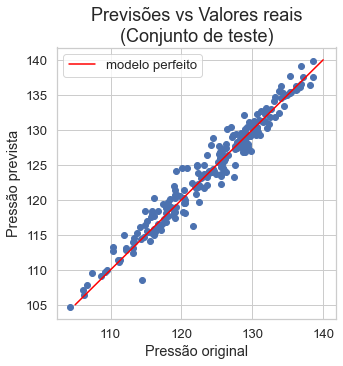

In [182]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(y_test_orig, test_pred)
ax.plot([105, 140], [105, 140], color='red', label='modelo perfeito')
ax.set_xlabel('Pressão original')
ax.set_ylabel('Pressão prevista')
ax.set_title('Previsões vs Valores reais\n(Conjunto de teste)', size=18)
plt.legend()

# Avaliação dos resultados

In [118]:
def plot_boxplot(results, col, title=''):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax = sns.boxplot(data=results, x=col, y='val_mse', ax=ax)
    ax.set_ylabel('MSE de validação')
    ax.set_title(title)
    return ax

### Resultado da determinação da arquitetura (etapa 1 da otimização da rede)

In [155]:
tuner = CustomRandomSearch(build_model, objective='mse', max_trials=20,
                           directory='results', project_name='pressure_prediction_nn_arch')

INFO:tensorflow:Reloading Oracle from existing project results\pressure_prediction_nn_arch\oracle.json
INFO:tensorflow:Reloading Tuner from results\pressure_prediction_nn_arch\tuner0.json


In [117]:
stage1_results = []
trials_ids = list(tuner.oracle.trials.keys())

for trial_id in trials_ids:
    trial = tuner.oracle.trials[trial_id]
    hyperparameters = trial.hyperparameters.values
    metrics = {i[0]: i[1].get_last_value() for i in trial.metrics.metrics.items()}
    
    trial_dict = {'id': trial_id}
    trial_dict.update(hyperparameters)
    trial_dict.update(metrics)
    
    stage1_results.append(trial_dict)

stage1_results = pd.DataFrame(stage1_results)
stage1_results.head()

,id,n_hidden_layers,activation_function,neurons_l1,batch_size,loss,mse,val_loss,val_mse,neurons_l2,neurons_l3
0,07a230214919217687bcf88ff288c100,1,sigmoid,120,160,0.016314,0.016314,0.016387,0.016387,NaN,NaN
1,02d1caec7dbcc0bb144650957d44a227,2,sigmoid,40,64,0.016462,0.016462,0.016598,0.016598,96.0,NaN
2,07f5eb91c569c6f6dd898f50a068cc40,3,sigmoid,40,64,0.015506,0.015506,0.015609,0.015609,24.0,112.0
3,229d146a16a4ff3ee00c6ca49333a437,3,sigmoid,40,224,0.026596,0.026596,0.025515,0.025515,104.0,8.0
4,1712be09023ebe34527c7b53efaf4ef2,2,relu,16,96,0.004384,0.004384,0.005459,0.005459,32.0,NaN


Podemos ver abaixo que, de forma geral, o uso da função de ativação relu gerou redes com menor erro do que com a função de ativação sigmoid para o problema em questão.

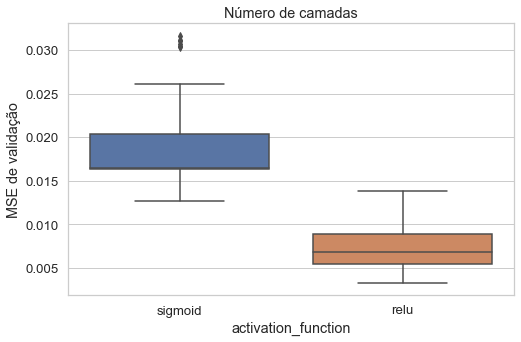

In [120]:
ax = plot_boxplot(stage1_results, 'activation_function', title='Número de camadas')

Text(0.5, 0.98, 'Impacto do número de parâmetros no erro')

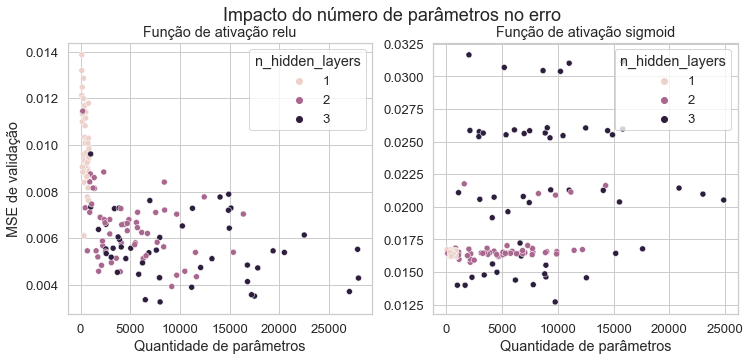

In [143]:
mask_1layer = (stage1_results['n_hidden_layers'] == 1)
mask_2layer = (stage1_results['n_hidden_layers'] == 2)
mask_3layer = (stage1_results['n_hidden_layers'] == 3)

stage1_results['numero_parametros'] = -1
stage1_results.loc[mask_1layer, 'numero_parametros'] = (5+1) * stage1_results.loc[mask_1layer, 'neurons_l1'] + \
                            (stage1_results.loc[mask_1layer, 'neurons_l1']+1)
stage1_results.loc[mask_2layer, 'numero_parametros'] = (5+1) * stage1_results.loc[mask_2layer, 'neurons_l1'] + \
                            (stage1_results.loc[mask_2layer, 'neurons_l1']+1) * stage1_results.loc[mask_2layer, 'neurons_l2'] + \
                            (stage1_results.loc[mask_2layer, 'neurons_l2']+1)
stage1_results.loc[mask_3layer, 'numero_parametros'] = (5+1) * stage1_results.loc[mask_3layer, 'neurons_l1'] + \
                            (stage1_results.loc[mask_3layer, 'neurons_l1']+1) * stage1_results.loc[mask_3layer, 'neurons_l2'] + \
                            (stage1_results.loc[mask_3layer, 'neurons_l2']+1) * stage1_results.loc[mask_3layer, 'neurons_l3'] + \
                            (stage1_results.loc[mask_3layer, 'neurons_l3']+1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax[0] = sns.scatterplot(data=stage1_results[stage1_results['activation_function'] == 'relu'], 
                        x='numero_parametros', y='val_mse', hue='n_hidden_layers', ax=ax[0])
ax[0].set_ylabel('MSE de validação')
ax[0].set_xlabel('Quantidade de parâmetros')
ax[0].set_title('Função de ativação relu')

ax[1] = sns.scatterplot(data=stage1_results[stage1_results['activation_function'] == 'sigmoid'], 
                        x='numero_parametros', y='val_mse', hue='n_hidden_layers', ax=ax[1])
ax[1].set_ylabel('')
ax[1].set_xlabel('Quantidade de parâmetros')
ax[1].set_title('Função de ativação sigmoid')

fig.suptitle('Impacto do número de parâmetros no erro', fontsize=18)

Text(0.5, 0.98, 'Impacto do tamanho do batch')

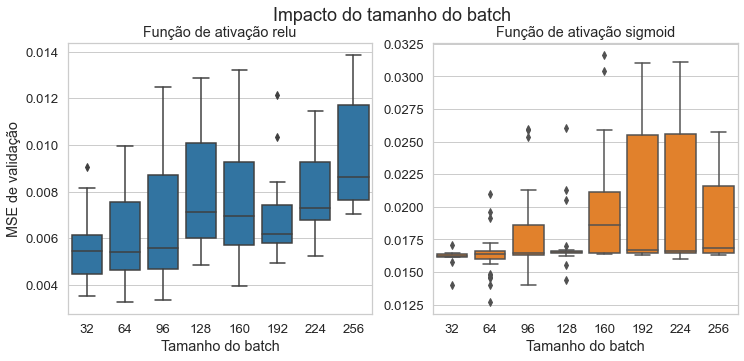

In [153]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax[0] = sns.boxplot(data=stage1_results[stage1_results['activation_function'] == 'relu'], 
                    x='batch_size', y='val_mse', color='tab:blue', ax=ax[0])
ax[0].set_ylabel('MSE de validação')
ax[0].set_xlabel('Tamanho do batch')
ax[0].set_title('Função de ativação relu')

ax[1] = sns.boxplot(data=stage1_results[stage1_results['activation_function'] == 'sigmoid'], 
                    x='batch_size', y='val_mse', color='tab:orange', ax=ax[1])
ax[1].set_ylabel('')
ax[1].set_xlabel('Tamanho do batch')
ax[1].set_title('Função de ativação sigmoid')

fig.suptitle('Impacto do tamanho do batch', size=18)

### Resultado do ajuste fino da arquitetura (etapa 2 da otimização da rede)

In [156]:
tuner2 = CustomRandomSearch(build_model, objective='mse', max_trials=20,
                            directory='results', project_name='pressure_prediction_nn_fine_tuning')

INFO:tensorflow:Reloading Oracle from existing project results\pressure_prediction_nn_fine_tuning\oracle.json
INFO:tensorflow:Reloading Tuner from results\pressure_prediction_nn_fine_tuning\tuner0.json


In [159]:
stage2_results = []
trials_ids = list(tuner2.oracle.trials.keys())

for trial_id in trials_ids:
    trial = tuner2.oracle.trials[trial_id]
    hyperparameters = trial.hyperparameters.values
    metrics = {i[0]: i[1].get_last_value() for i in trial.metrics.metrics.items()}
    
    trial_dict = {'id': trial_id}
    trial_dict.update(hyperparameters)
    trial_dict.update(metrics)
    
    stage2_results.append(trial_dict)

stage2_results = pd.DataFrame(stage2_results)
stage2_results.head()

,id,learning_rate,regularization,l2,loss,mse,val_loss,val_mse,l1
0,0385086b91bf9fc98f30d923fbfff3e4,0.150196,l2,0.005506,1.450679,0.019805,1.164486,0.019363,NaN
1,0765df4bcd3201265d2c3e2f8f3b6613,0.014420,l1,NaN,6.114939,0.082945,5.937774,0.067760,0.494425
2,1090fedeb7b3d0e3664a75abbe929970,0.015952,elasticinet,0.176826,0.201470,0.038727,0.190779,0.032835,0.010841
3,07f9bb3aa121651e55dabb13315b11d7,0.160149,l1,NaN,0.989904,0.020026,0.980593,0.019590,0.000908
4,0c06c1d90ae0efd36dc72684cd9fb158,0.015619,elasticinet,0.010244,0.047016,0.032651,0.045177,0.030856,0.000932


In [160]:
stage2_results['regularization'].value_counts()

l2             80
None           79
l1             77
elasticinet    64
Name: regularization, dtype: int64

Text(0.5, 1.0, 'Impacto dos tipos de regularização')

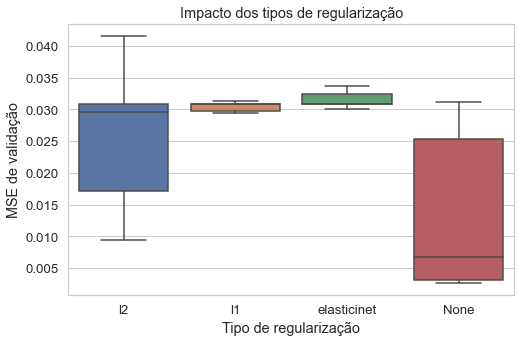

In [166]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.boxplot(data=stage2_results, x='regularization', y='val_mse', showfliers=False, ax=ax)
ax.set_xlabel('Tipo de regularização')
ax.set_ylabel('MSE de validação')
ax.set_title('Impacto dos tipos de regularização')

Text(0.5, 1.0, 'Impacto da taxa de aprendizado')

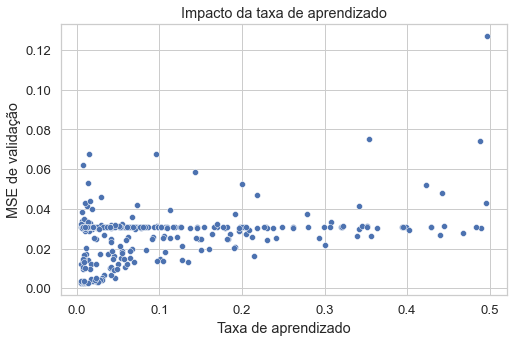

In [169]:
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.scatterplot(data=stage2_results[stage2_results['val_mse'] < 0.75], 
                     x='learning_rate', y='val_mse', ax=ax)
ax.set_ylabel('MSE de validação')
ax.set_xlabel('Taxa de aprendizado')
ax.set_title('Impacto da taxa de aprendizado')